In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.init as init
from time import time
from torchvision.transforms import Compose, ToTensor
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable
import numpy as np
import torchvision.utils as v_utils
import os 
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer

## Dataset Class

In [2]:
class Dataset(Dataset):
  def __init__(self, x, y, n):
    self.x = torch.FloatTensor(x).view(n,1,28,28)
    self.y = torch.FloatTensor(y)

  def __len__(self):
    return len(self.x)
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]


class Data:
  def __init__(self, config):
    transform = Compose([ToTensor()])
    self.normal_num = config['normal_num']
    self.ratio = config['ratio']
    self.train_dataset, self.test_dataset = self.load_data()

  def load_data(self):

    train_dataset = datasets.MNIST(root="MNIST/processed/training.pt", train=True,  download=config['download'])
    train_x, train_y = train_dataset.data, train_dataset.targets
    test_dataset = datasets.MNIST(root="MNIST/processed/test.pt", train=False,  download=config['download'])
    test_x, test_y = test_dataset.data, test_dataset.targets
    train_x, train_y = self.preprocessing(train_x, train_y, self.normal_num, self.ratio, True)
    test_x, test_y = self.preprocessing(test_x, test_y, self.normal_num, self.ratio, False)
    n = len(train_x)
    n_ = len(test_x)
    return Dataset(train_x, train_y, n), Dataset(test_x, test_y, n_)

  def preprocessing(self, x, y, normal_num, ratio, train):
    """
    Train Dataset에는 모두 0인 것만 포함시키기
    Test Dataset에는 0이 0.8개, 나머지는 0.2개를 포함시키기
    """
    x = x/255.0
    N = len(x)
    processing_x = []
    processing_y = []
    for i in range(N):
      if y[i] == normal_num:
        processing_x.append(x[i].reshape(-1).tolist())
        processing_y.append([y[i].tolist()])
    num_normal_data = len(processing_x)
    print("number of normal data: {}".format(num_normal_data))
    i = 0
    while(1):
      if train:
          break
      if len(processing_x) > num_normal_data*(1+self.ratio):
        break
      if y[i] != normal_num:
        processing_x.append(x[i].reshape(-1).tolist())
        processing_y.append([y[i].tolist()])
      i += 1
    print("number of abnormal data: {}".format(len(processing_x)-num_normal_data))
    return processing_x, processing_y


Extracting MNIST/processed/training.pt/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/processed/training.pt/MNIST/raw




Extracting MNIST/processed/training.pt/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/processed/training.pt/MNIST/raw




Extracting MNIST/processed/training.pt/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/processed/training.pt/MNIST/raw




Extracting MNIST/processed/training.pt/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/processed/training.pt/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Extracting MNIST/processed/test.pt/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/processed/test.pt/MNIST/raw




Extracting MNIST/processed/test.pt/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/processed/test.pt/MNIST/raw




Extracting MNIST/processed/test.pt/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/processed/test.pt/MNIST/raw




Extracting MNIST/processed/test.pt/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/processed/test.pt/MNIST/raw

Processing...
Done!
number of normal data: 5923
number of abnormal data: 0
number of normal data: 980
number of abnormal data: 99


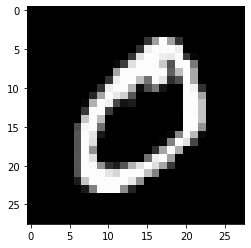

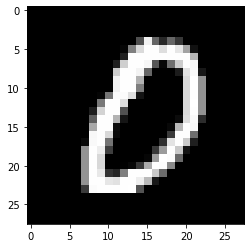

In [4]:
config = {
    "normal_num": 0,
    "ratio": 0.1,
    "batch_size": 65,
    'threshold': 0.08,
    'epoch': 200,
    'learning_rate': 0.0002,
    'download': True # MNIST를 다운할 것인지
}
data =Data(config)
train_loader = torch.utils.data.DataLoader(dataset=data.train_dataset,batch_size=config['batch_size'],shuffle=True,drop_last=True)
plt.imshow(train_loader.dataset.x[0][0],cmap='gray')
plt.show()
plt.imshow(train_loader.dataset.x[400][0],cmap='gray')


## Discriminator와 Generator Class

In [5]:
class Discriminator(nn.Module):
    def __init__(self,config):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3,stride=2,padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        #('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        #nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature
        
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out


In [6]:
start = timer()
generator = Generator().cuda()
discriminator = Discriminator(config).cuda()
print("GPU의 할당시간 : {:4f}".format(timer()-start))
try:
    generator.load_state_dict(torch.load('./saved_model/generator.pkl'))
    discriminator.load_state_dict(torch.load('./saved_model/discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

GPU의 할당시간 : 10.877252

--------model not restored--------



In [7]:
loss_func = nn.MSELoss()

ones_label = torch.ones(config['batch_size'],1).cuda()
zeros_label = torch.zeros(config['batch_size'],1).cuda()

gen_optim = torch.optim.Adam(generator.parameters(), lr= 5*config['learning_rate'],betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=config['learning_rate'],betas=(0.5,0.999))

In [8]:

def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(2):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

## Early Stop 용도

In [9]:
max_loss = 10000000.0
max_count = 10
cur_count = 0

## Main 부분

0th iteration gen_loss: 0.13160587847232819 dis_loss: 0.7520774006843567
Time : 35.252826


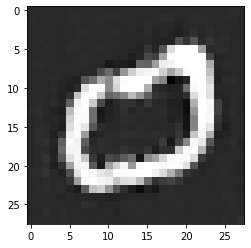

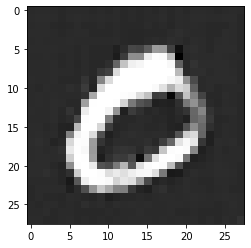

In [10]:
start = timer()
generator.train()
discriminator.train()
for i in range(config['epoch']):
    total_loss = 0.0
    for j,(image,label) in enumerate(train_loader):
        image = image.cuda()
        
        # generator
        gen_optim.zero_grad()
        
        z = init.normal_(torch.Tensor(config['batch_size'],100).cuda(),mean=0,std=0.1)
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward(retain_graph=True)
        gen_optim.step()
    
        # discriminator
        dis_optim.zero_grad()
        
        z = Variable(init.normal_(torch.Tensor(config['batch_size'],100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        dis_real,_ = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward()
        dis_optim.step()
        total_loss += (gen_loss.detach().item()+ dis_loss.detach().item())
        # model save
        if i % 20 == 0 and j==0:
              #print(gen_loss,dis_loss)
              print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            
    
    # Early Stop 용도
    if total_loss < max_loss:
      max_loss = total_loss
      cur_count = 0
    else:
      cur_count += 1
      if cur_count == max_count:
        torch.save(generator.state_dict(),'saved_model/generator.pkl')
        torch.save(discriminator.state_dict(),'saved_model/discriminator.pkl')
        v_utils.save_image(gen_fake.data[0:25],"result/gen_{}_{}.png".format(i,j), nrow=5)
        break
      
print("Time : {:4f}".format(timer()-start))
image_check(gen_fake.cpu())

In [11]:
def Anomaly_score(x,G_z,Lambda=0.1):
    _,x_feature = discriminator(x)
    _,G_z_feature = discriminator(G_z)
    
    residual_loss = torch.sum(torch.abs(x-G_z))
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature))
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss

In [12]:
z = Variable(init.normal(torch.zeros(len(data.test_dataset),100).cuda(),mean=0,std=0.1),requires_grad=True)
z_optimizer = torch.optim.Adam([z],lr=1e-4)

gen_fake = generator(z)
test_data =  data.test_dataset.x.view(-1,1,28,28).cuda()
loss = Anomaly_score(test_data,gen_fake)
print(loss.item())

272581.90625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """Entry point for launching an IPython kernel.


In [13]:
start = timer()
for i in range(5000):
    z_optimizer.zero_grad()
    gen_fake = generator(z)
    loss = Anomaly_score(test_data,gen_fake,Lambda=0.01)
    loss.backward()
    z_optimizer.step()
    
    if i%1000==0:
        print(loss.cpu().data)
print("Time : {:4f}".format(timer()-start))

tensor(154961.1875)
tensor(67185.6562)
tensor(54118.0391)
tensor(48473.4805)
tensor(45535.5469)
Time : 1569.452797


In [77]:
gen_fake = generator(z)

_,x_feature = discriminator(test_data)
_,G_z_feature = discriminator(gen_fake)
test_flatten = test_data.view(test_data.shape[0],-1)
gen_fake_flatten = gen_fake.view(gen_fake.shape[0],-1)
resiudal_loss = torch.sum(torch.abs(test_flatten-gen_fake_flatten), axis = 1)
disc_loss = torch.sum(torch.abs(x_feature-G_z_feature), axis = 1)
total_loss = (1-0.01)*resiudal_loss + 0.01*disc_loss

In [78]:
y = data.test_dataset.y.numpy().squeeze(1)


In [79]:
total_loss = total_loss.detach().cpu().numpy()
zero = y==0.
nonzero = y!=0.

In [80]:
import pandas as pd

In [89]:
dat = np.vstack([y,total_loss]).T

In [90]:

df = pd.DataFrame(dat, columns = ['y', 'score'])

In [63]:


df.head()

,y,score
0,0.0,78.331894
1,0.0,29.804358
2,0.0,28.720989
3,0.0,53.873363
4,0.0,30.918121


In [92]:
print("Anomaly의 score : {:4f}".format(np.mean(df[df['y']!=0.0]['score'])))

Anomaly의 score : 60.137028


In [94]:
print("정상 score : {:4f}".format(np.mean(df[df['y']==0.0]['score'])))

정상 score : 38.621567


## AUC 구하기

In [101]:

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(df['y'], df['score'], pos_label = 2)
metrics.auc(fpr, tpr)

0.8697819314641745

## 0의 anomaly Score - 중간값을 Threshold로 이용

In [102]:
median_score = np.median(df['score'])
median_score

33.573654

## Anomaly Detection 비율

In [103]:
n_z = total_loss[nonzero]
y_z = total_loss[zero]
print("Recall : {:4f}".format(len(n_z[n_z>33.573647]) / len(n_z)))

Recall : 0.959596


## 어떤 image가 Anomaly Score가 낮은지 확인

In [104]:
indx = df[(df['y']!=0.0)&(df['score']<33.573654)]

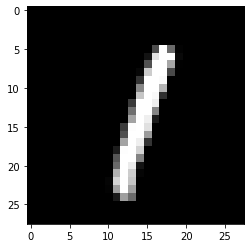

real data


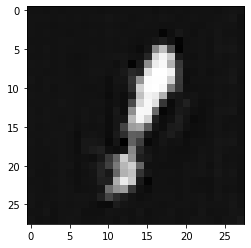

generated data

------------------------------------



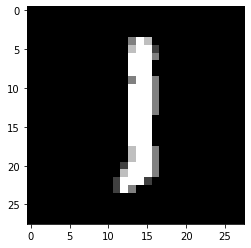

real data


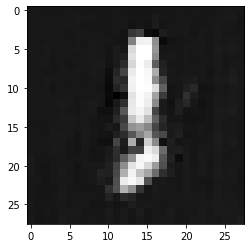

generated data

------------------------------------



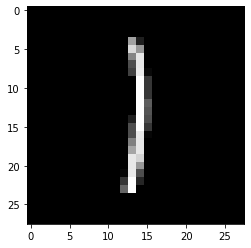

real data


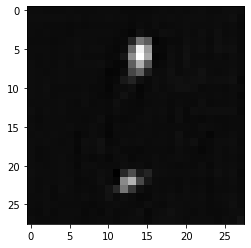

generated data

------------------------------------



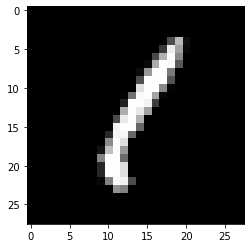

real data


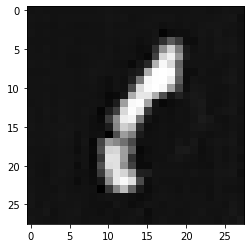

generated data

------------------------------------



In [108]:
for idx in indx.index:
    target = test_data[idx,0,:,:]
    plt.imshow(target.cpu().numpy(),cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:]
    plt.imshow(img,cmap='gray')
    plt.show()
    print("generated data")
    print("\n------------------------------------\n")

## 0이 아닌 것은 이상하게 Generate됨(Latent Space에서 찾지 못함)

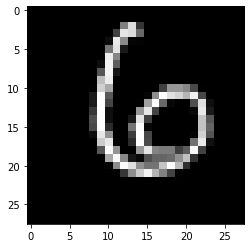

real data


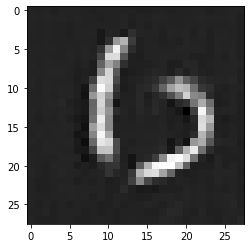

generated data

------------------------------------



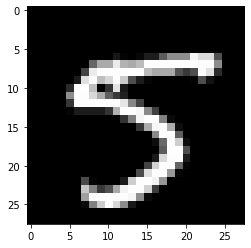

real data


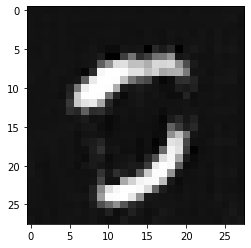

generated data

------------------------------------



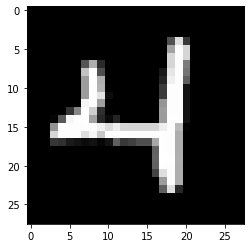

real data


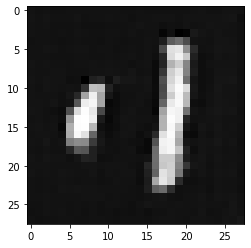

generated data

------------------------------------



In [24]:
for idx in range(1072,1075):
    target = test_data[idx,0,:,:]
    plt.imshow(target.cpu().numpy(),cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:]
    plt.imshow(img,cmap='gray')
    plt.show()
    print("generated data")
    print("\n------------------------------------\n")

## Test에서 0인 데이터는 잘 Generate됨

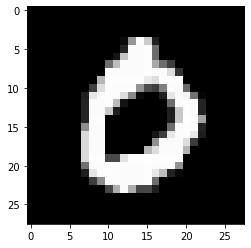

real data


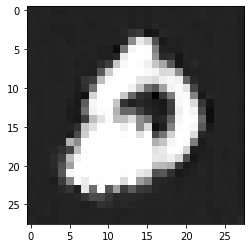

generated data

------------------------------------



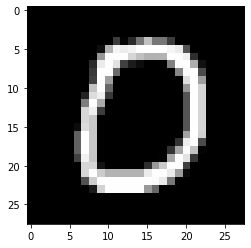

real data


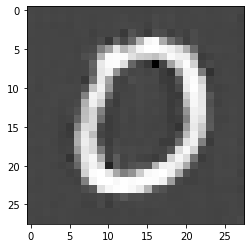

generated data

------------------------------------



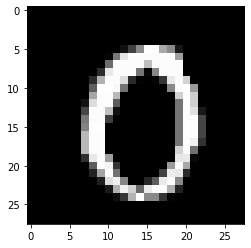

real data


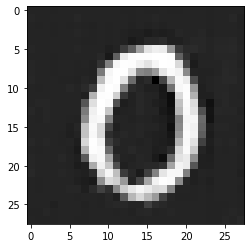

generated data

------------------------------------



In [25]:
for idx in range(0,3):
    target = test_data[idx,0,:,:]
    plt.imshow(target.cpu().numpy(),cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:]
    plt.imshow(img,cmap='gray')
    plt.show()
    print("generated data")
    print("\n------------------------------------\n")